---
title: "Lab 2, STAT 214 Spring 2025"
author: "Luna Kim, Connor Pestell, Zhaoyi Zhang, Kathy Li"
date: "3/21/2025"
execute:
    echo: False  
format:
  pdf:
    code-fold: true
    documentclass: scrartcl
    geometry: margin=1in
    code-overflow: wrap
    fontsize: 10pt
    header-includes:
      - \let\arrowvert\relax
      - \usepackage{graphicx}  # Ensures LaTeX can handle images
      - \usepackage{float}  # Helps control figure positioning
      - \usepackage{newtxtext,newtxmath}  % Sets Times New Roman-like fonts for text and math
      - \setlength{\parindent}{0em}
---

# 1 Introduction

Cloud detection in polar regions presents a significant scientific and statistical challenge due to the similar spectral and radiative properties shared by clouds and snow- or ice-covered surfaces. Accurate identification of clouds is critical for climate modeling, as clouds play a dual role in Earth's energy balance—contributing to warming by trapping heat and to cooling by reflecting sunlight. However, traditional cloud detection methods often struggle in the Arctic, where the low contrast between clouds and the surface in visible and infrared wavelengths limits their effectiveness.

In this lab, we develop a cloud detection algorithm using data from NASA’s Multi-angle Imaging SpectroRadiometer (MISR) onboard the Terra satellite. The primary goal is to build a predictive model that distinguishes cloud from non-cloud pixels in MISR imagery. MISR captures radiance from multiple viewing angles, providing valuable information about the vertical structure of the atmosphere. This multi-angle perspective aids cloud identification by leveraging altitude and scattering characteristics, rather than relying solely on brightness or temperature. Satellite imagery contributes to climate analysis through two key observations: different objects exhibit distinct radiative signatures (colors), and measurements taken closer to the Earth’s surface tend to reflect higher temperatures.

In addition to raw radiance data, we incorporate three engineered features—NDAI (Normalized Difference Angular Index), SD (Standard Deviation), and CORR (Correlation)—which are designed to enhance cloud detection accuracy. These features are informed by domain-specific knowledge and have demonstrated effectiveness in differentiating clouds from background surfaces.

This project is structured into several components: Exploratory Data Analysis (EDA), feature engineering, model selection, and model evaluation. Through these steps, we aim to explore the data, develop informative features, build robust models, and assess their predictive performance. We will also discuss the broader implications of our findings for climate science and highlight opportunities for future research.

# 2 Data

## 2.1  Data Collection and Description

The dataset used in this lab was collected from NASA’s Multi-angle Imaging SpectroRadiometer (MISR) onboard the Terra satellite. MISR captures satellite imagery in the red spectral band from nine different camera angles, which provides unique information about surface and atmospheric characteristics—especially helpful in distinguishing clouds from snow or ice in polar regions.

For this project, we worked with 164 image files in .npz format, each representing a different MISR scene. Every image contains pixel-level data across ten features, including spatial coordinates (X, Y), radiance values from five MISR angles (DF, CF, BF, AF, AN), and three engineered features: NDAI (Normalized Difference Angular Index), SD (Standard Deviation of radiance), and CORR (Correlation between angular radiances). These engineered features were developed by researchers based on domain expertise to enhance cloud detection performance in complex terrains.

Each pixel also includes a label indicating the presence or absence of a cloud: +1 for cloud, -1 for no cloud, and 0 for unlabeled pixels. However, only three images—O013257.npz, O013490.npz, and O012791.npz—contain expert-annotated labels, which we use as ground truth during our model development and evaluation phases. The remaining 161 images are unlabeled and serve as potential candidates for model inference after training.

This structured dataset allows us to explore how both raw radiance data and derived features can help distinguish clouds from background surfaces, while also reflecting the challenges of working with real-world satellite imagery that includes noise, class imbalance, and limited labeled data.

## 2.2 Data Cleaning

In [6]:
# Load necessery packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

print(os.getcwd())

d:\Desktop\Berkeley\STAT 214 Data Analysis and ML\stat-214\lab2\code


In [7]:
# Read the raw dataset
# data_path = '/Users/rurulala3265/Downloads/_Berkeley/_stat214/stat-214/lab2/data/O002772.npz' # change it to your own path
# data_path = '~/stat-214/lab2/data/O002539.npz' # data path for my report
data_path = 'd:/Desktop/Berkeley/STAT 214 Data Analysis and ML/stat-214/lab2/data/image_data/O002772.npz'

data = np.load(data_path)

# Check what arrays are inside
print(data.files)
print(data['arr_0']) 

['arr_0']
[[2.00000000e+00 6.60000000e+01 9.34292749e-02 ... 8.18966650e+03
  7.56800000e+03 7.43433350e+03]
 [2.00000000e+00 6.70000000e+01 1.57574058e-01 ... 9.47125000e+03
  8.54350000e+03 8.22650000e+03]
 [2.00000000e+00 6.80000000e+01 9.00644213e-02 ... 9.76350000e+03
  9.30575000e+03 8.86300000e+03]
 ...
 [3.83000000e+02 3.64000000e+02 1.35627165e-01 ... 2.84125000e+04
  2.65247500e+04 2.40602500e+04]
 [3.83000000e+02 3.65000000e+02 1.34893134e-01 ... 2.83665000e+04
  2.65050000e+04 2.40570000e+04]
 [3.83000000e+02 3.66000000e+02 1.34661451e-01 ... 2.83540000e+04
  2.65125000e+04 2.40205000e+04]]


In [8]:
# data_dir = '/Users/rurulala3265/Downloads/_Berkeley/_stat214/stat-214/lab2/data/' # Full data file directorie
data_dir = 'd:/Desktop/Berkeley/STAT 214 Data Analysis and ML/stat-214/lab2/data/image_data/' # change it to your own path

all_files = [f for f in os.listdir(data_dir) if f.endswith('.npz')]

columns = [
    'Y', 'X', 'NDAI', 'SD', 'CORR',
    'Radiance_DF', 'Radiance_CF', 'Radiance_BF', 'Radiance_AF', 'Radiance_AN', 'Label'
]

# Load all .npz files into one large DataFrame
all_data = []

for file in all_files:
    filepath = os.path.join(data_dir, file)
    npz_data = np.load(filepath)
    arr = npz_data['arr_0']
    
    # Handle short arrays (some may not have expert labels, only 10 columns)
    if arr.shape[1] == 10:
        temp_df = pd.DataFrame(arr, columns=columns[:-1])
        temp_df['Label'] = 0  # Assume unlabeled
    else:
        temp_df = pd.DataFrame(arr, columns=columns)
        
    temp_df['image_id'] = file  # Track source image
    all_data.append(temp_df)

# Concatenate everything
df_full = pd.concat(all_data, ignore_index=True)

In [9]:
print(df_full["Label"].value_counts())

Label
 0.0    18726948
-1.0      126716
 1.0       80965
Name: count, dtype: int64


In [10]:
print(df_full.isna().sum()) # no NA's
print(df_full.describe())
print(df_full.shape)

Y              0
X              0
NDAI           0
SD             0
CORR           0
Radiance_DF    0
Radiance_CF    0
Radiance_BF    0
Radiance_AF    0
Radiance_AN    0
Label          0
image_id       0
dtype: int64
                  Y             X          NDAI            SD          CORR  \
count  1.893463e+07  1.893463e+07  1.893463e+07  1.893463e+07  1.893463e+07   
mean   1.930251e+02  2.169185e+02  2.004957e-01  5.754315e+02  5.079496e-01   
std    1.102642e+02  8.727746e+01  1.035793e-01  7.059685e+02  3.863470e-01   
min    2.000000e+00  5.700000e+01 -6.123912e-01  5.656854e+00 -9.765562e-01   
25%    9.800000e+01  1.410000e+02  1.294750e-01  9.699843e+01  2.103757e-01   
50%    1.930000e+02  2.170000e+02  1.713340e-01  3.335365e+02  5.997756e-01   
75%    2.890000e+02  2.920000e+02  2.513019e-01  7.590168e+02  8.546392e-01   
max    3.830000e+02  3.730000e+02  9.374210e-01  9.729683e+03  9.840799e-01   

        Radiance_DF   Radiance_CF   Radiance_BF   Radiance_AF   Radianc

In [11]:
# Filter out unlabeled if you only want labeled data
df_labeled = df_full[df_full['Label'] != 0].copy()
print('Labeled dataFrame before cleaning shape: ', df_labeled.shape)

Labeled dataFrame before cleaning shape:  (207681, 12)


In [12]:
# ===== Data Cleaning =====

# Normalize features (we n)
from sklearn.preprocessing import StandardScaler

# Remove outliers in NDAI
df_labeled = df_labeled[(df_labeled['NDAI'] >= -1) & (df_labeled['NDAI'] <= 1)]

# Remove invalid SD values only
df_labeled = df_labeled[df_labeled['SD'] >= 0]

# Drop rows with any NaN or infinite values (precautionary step)
df_labeled = df_labeled.replace([np.inf, -np.inf], np.nan)
df_labeled = df_labeled.dropna()

# Remove extreme outliers (use quantile instead of arbitrary cutoffs)
for col in ['NDAI', 'SD', 'CORR']:
    lower_q = df_labeled[col].quantile(0.01)
    upper_q = df_labeled[col].quantile(0.99)
    df_labeled = df_labeled[(df_labeled[col] >= lower_q) & (df_labeled[col] <= upper_q)]

features = ['NDAI', 'SD', 'CORR', 'Radiance_DF', 'Radiance_CF', 'Radiance_BF', 'Radiance_AF', 'Radiance_AN']

scaler = StandardScaler()
df_labeled[features] = scaler.fit_transform(df_labeled[features])

print('Final Labeled dataFrame shape: ', df_labeled.shape)


Final Labeled dataFrame shape:  (195465, 12)


In [13]:
df_full.head()

,Y,X,NDAI,SD,CORR,Radiance_DF,Radiance_CF,Radiance_BF,Radiance_AF,Radiance_AN,Label,image_id
0,2.0,67.0,0.252645,989.380432,-0.037011,25854.75,24105.50,21934.50,17938.25,15425.50,0.0,O002539.npz
1,2.0,68.0,0.221815,1321.251465,0.035111,26651.00,23038.50,22098.50,19068.25,16974.25,0.0,O002539.npz
2,2.0,69.0,0.231423,984.155518,-0.217875,27540.00,20284.00,20124.25,19210.75,17188.75,0.0,O002539.npz
3,2.0,70.0,0.251133,853.619812,-0.077692,27950.00,19708.00,20084.25,20451.75,16729.50,0.0,O002539.npz
4,2.0,71.0,0.215065,1091.303223,-0.090391,27342.75,20977.25,20246.75,21187.50,17663.50,0.0,O002539.npz


In [14]:
df_labeled.head()

,Y,X,NDAI,SD,CORR,Radiance_DF,Radiance_CF,Radiance_BF,Radiance_AF,Radiance_AN,Label,image_id
1617349,2.0,190.0,-0.112875,4.002996,0.504248,-0.029596,-0.340031,-0.000887,0.240420,0.046233,-1.0,O012791.npz
1617353,2.0,194.0,2.243195,3.151506,-0.462898,-1.182192,-3.470463,-2.342903,-2.549642,-2.474564,-1.0,O012791.npz
1617354,2.0,195.0,3.066103,2.672448,0.246140,-0.303589,-3.305399,-2.731092,-2.710720,-2.587621,-1.0,O012791.npz
1617358,2.0,199.0,-0.477792,3.466308,0.341774,-0.231033,-0.293801,0.694623,0.180924,0.255313,-1.0,O012791.npz
1617364,2.0,205.0,-0.508732,4.533183,1.251526,-2.018908,-1.848842,-1.609046,-1.260409,-1.200814,-1.0,O012791.npz


In [15]:
print("===== After Data cleaning =====")
print(df_labeled["image_id"].unique())

===== After Data cleaning =====
['O012791.npz' 'O013257.npz' 'O013490.npz']


# 3 EDA and Split Train/Test dataset

## 3.2 EDA

In [16]:
labeled_files = ['O013257.npz', 'O013490.npz', 'O012791.npz']

columns = [
    'Y', 'X', 'NDAI', 'SD', 'CORR',
    'Radiance_DF', 'Radiance_CF', 'Radiance_BF', 'Radiance_AF', 'Radiance_AN', 'Label'
]

dfs = []
for file in labeled_files:
    path = os.path.join(data_dir, file)
    data = np.load(path)['arr_0']
    df = pd.DataFrame(data, columns=columns)
    df['image_id'] = file
    dfs.append(df)

df_3images = pd.concat(dfs, ignore_index=True)
df_3images_labeled = df_3images[df_3images['Label'] != 0].copy()

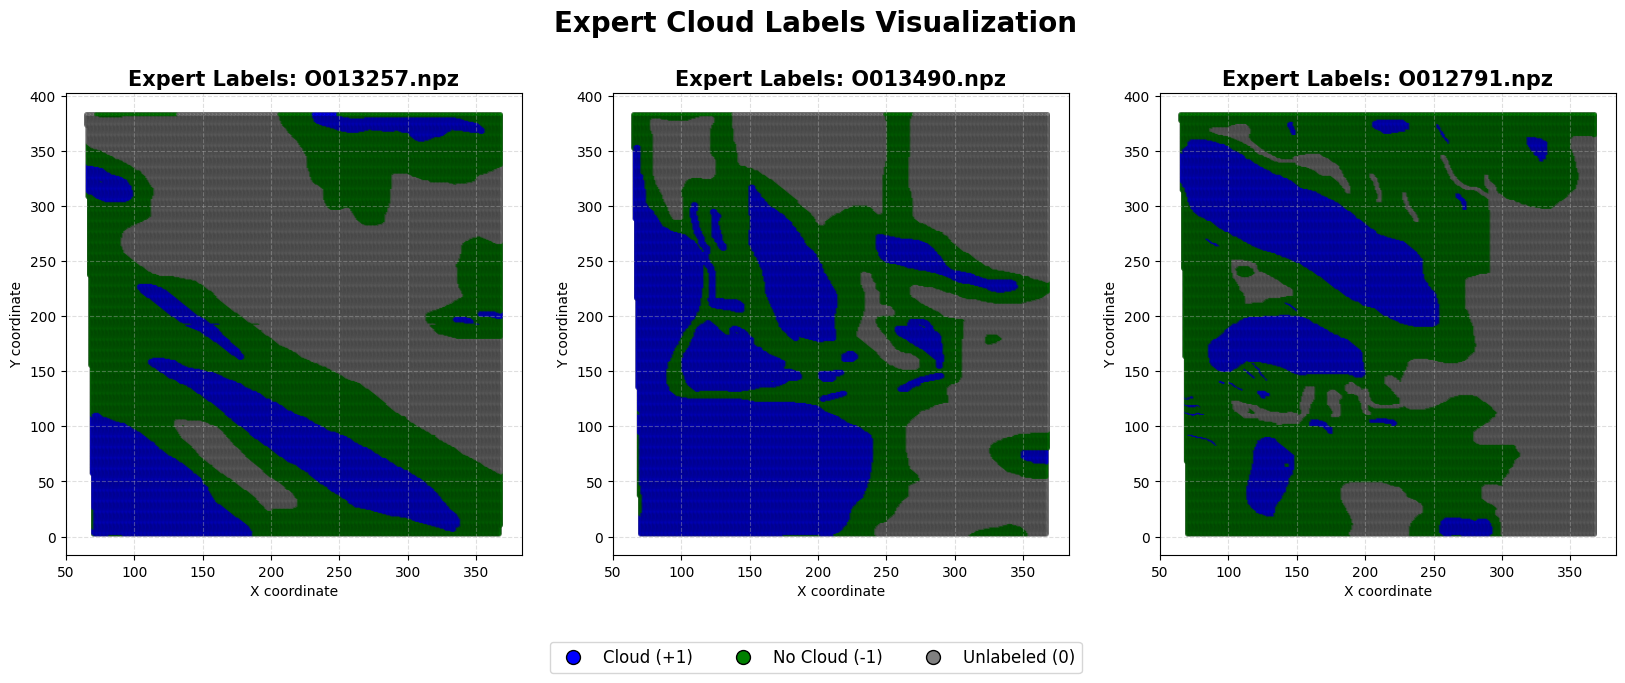

In [17]:
# ===== Plot of Expert Labels on a Map =====
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

label_colors = ListedColormap(['gray', 'green', 'blue'])  # -1: green (No Cloud), 0: gray (Unlabeled), +1: blue (Cloud)
label_names = {-1: 'No Cloud', 0: 'Unlabeled', 1: 'Cloud'}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, file in enumerate(labeled_files):
    ax = axes[i]
    df = df_3images[df_3images['image_id'] == file]
    scatter = ax.scatter(
        df['X'], df['Y'], c=df['Label'], cmap=label_colors,
        s=8, alpha=0.7, edgecolors='black', linewidths=0.2
    )
    ax.set_title(f"Expert Labels: {file}", fontsize=15, fontweight='bold')
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    ax.grid(True, linestyle='--', alpha=0.4)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Cloud (+1)', markerfacecolor='blue', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='No Cloud (-1)', markerfacecolor='green', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='Unlabeled (0)', markerfacecolor='gray', markersize=10, markeredgecolor='k')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.02),
           ncol=3, fontsize=12, frameon=True)
plt.suptitle("Expert Cloud Labels Visualization", fontsize=20, fontweight='bold', y=1.02)
plt.show()

The spatial visualizations of expert-labeled cloud masks across the three images (O013257, O013490, and O012791) show clear patterns in how clouds and non-cloud regions are distributed. Cloud-labeled pixels (+1) and no-cloud pixels (-1) appear in distinct clusters, often aligned along certain altitudes or terrain features, while unlabeled areas (0) typically form the background. These plots demonstrate that spatial information (X, Y) may be useful for modeling local patterns, but more importantly, they reveal that clouds and no-cloud areas often occur in separate, structured regions, supporting the feasibility of spatially aware classification methods.

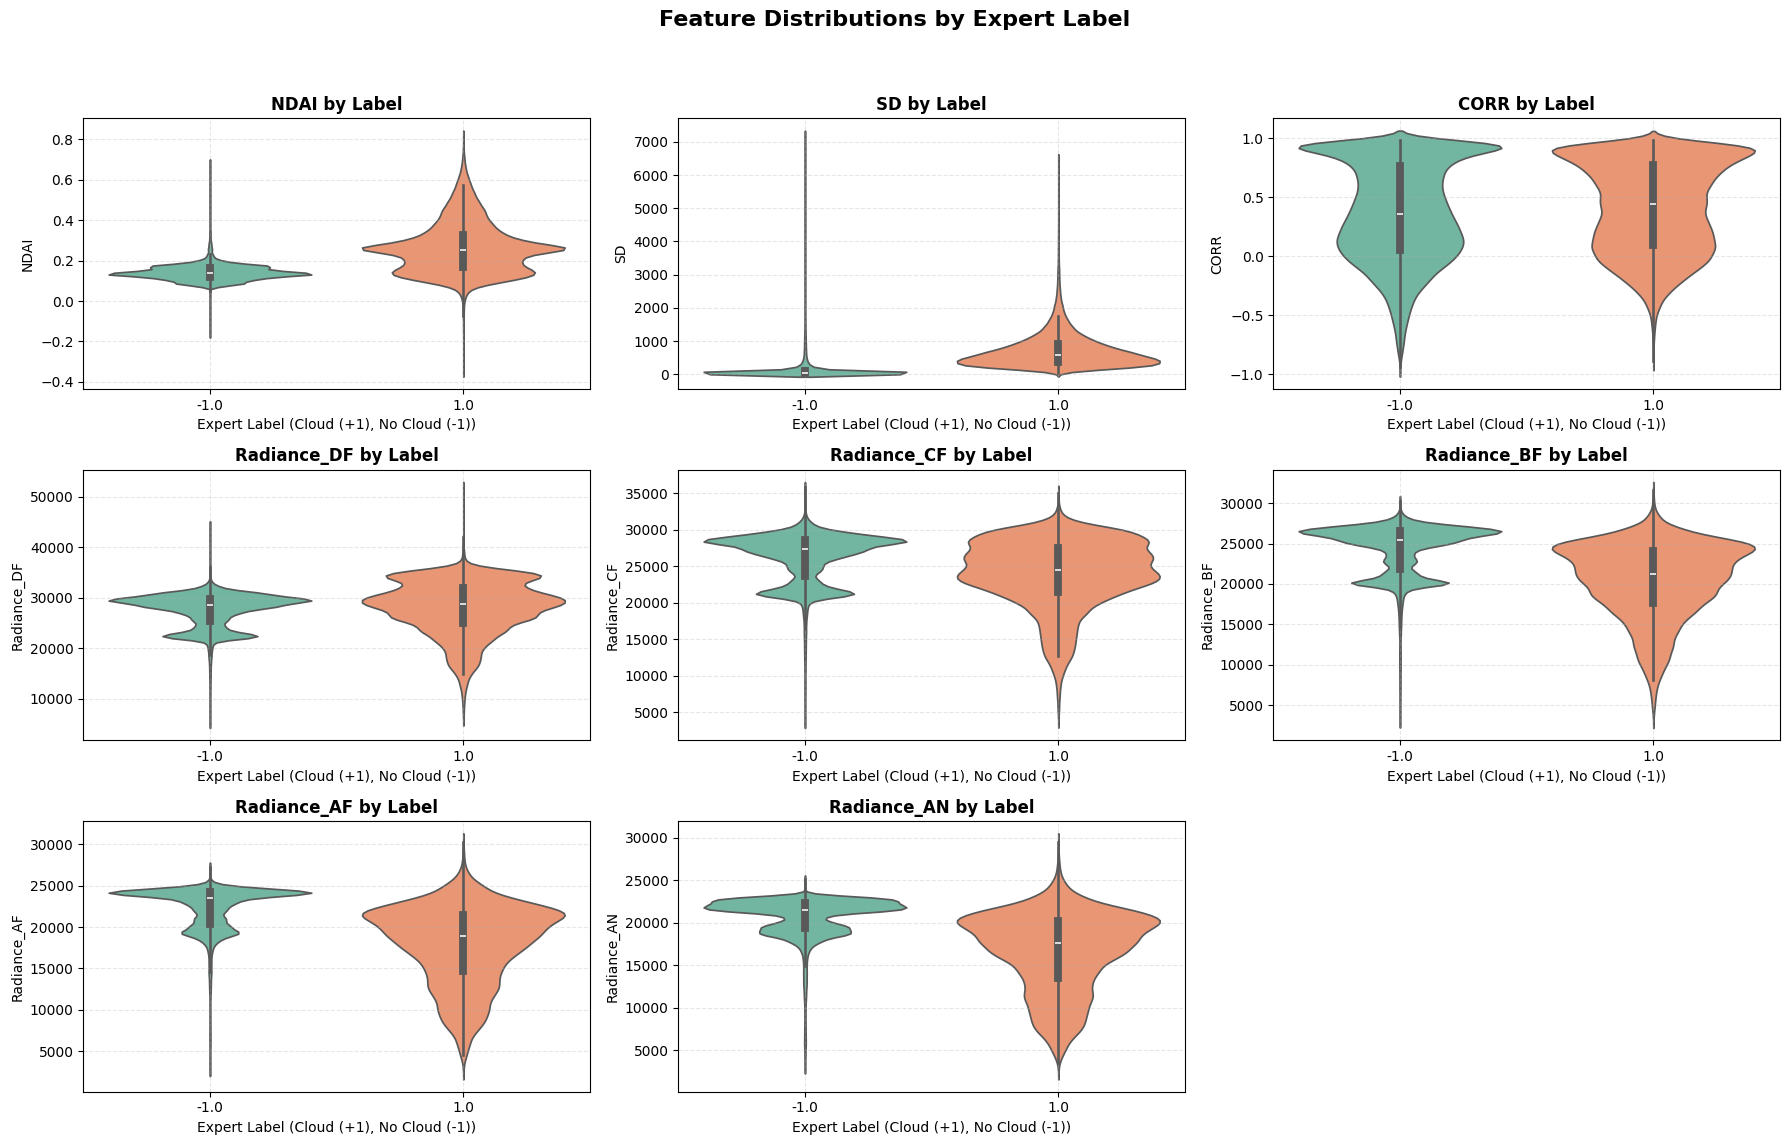

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ===== Radiance and Feature Relationship Analysis =====
features_to_plot = ['NDAI', 'SD', 'CORR', 'Radiance_DF', 'Radiance_CF', 'Radiance_BF', 'Radiance_AF', 'Radiance_AN']
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    sns.violinplot(ax=axes[idx], data=df_3images_labeled, x='Label', y=feature, inner='box', palette='Set2')
    axes[idx].set_title(f"{feature} by Label", fontsize=12, fontweight='bold')
    axes[idx].set_xlabel("Expert Label (Cloud (+1), No Cloud (-1))")
    axes[idx].set_ylabel(feature)
    axes[idx].grid(True, linestyle='--', alpha=0.3)

for i in range(len(features_to_plot), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle("Feature Distributions by Expert Label", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The violin plots comparing feature distributions across cloud and no-cloud classes provide deeper insight into the relationships between radiance and cloud presence. NDAI shows clear class separation—values are generally higher for cloud pixels, indicating its effectiveness as a discriminative feature. Similarly, SD and CORR distributions show meaningful differences, although SD is more skewed and may require normalization. Radiance values across the MISR angles also differ between classes; in particular, cloud pixels tend to have higher or more variable radiance across multiple angles, suggesting that the angular scattering properties captured by MISR are indeed informative. These plots confirm that multiple features—not just one—carry useful signal for separating clouds from background.

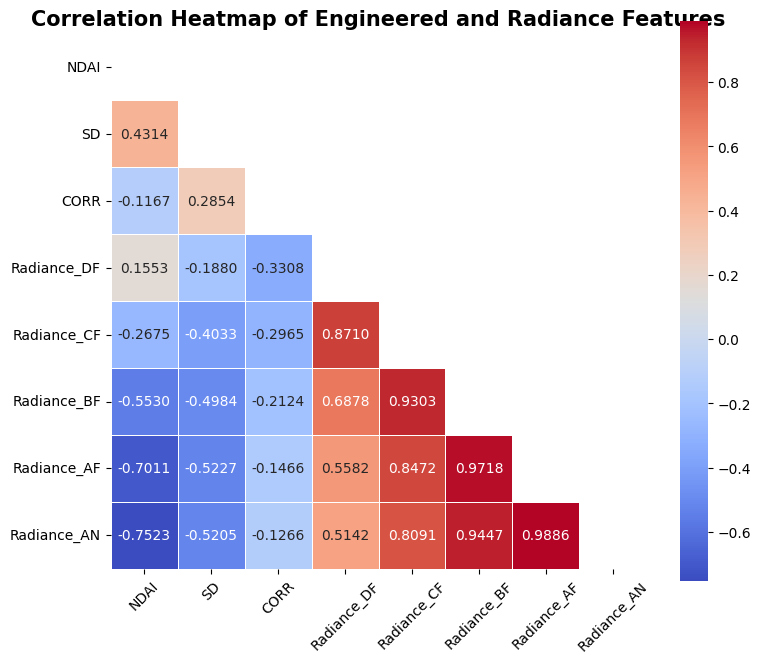

In [19]:
# ===== Correlation Heatmap ===== 
numeric_df = df_3images_labeled.select_dtypes(include='number').drop(columns=['X', 'Y', 'Label'])
correlation = numeric_df.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))

plt.figure(figsize=(8, 8))
sns.heatmap(correlation, mask=mask, cmap='coolwarm', annot=True, fmt=".4f",
            square=True, linewidths=0.6, cbar_kws={"shrink": 0.75}, annot_kws={"size":10})
plt.title("Correlation Heatmap of Engineered and Radiance Features", fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

While radiance values across different angles are strongly correlated with each other (especially among BF, AF, and AN), engineered features like NDAI and CORR show weaker correlations with raw radiance. This indicates that NDAI, SD, and CORR introduce additional, non-redundant information to the model. Interestingly, NDAI is negatively correlated with most radiance features, reflecting how the angular differences contribute to its calculation. These relationships highlight that while radiance angles provide foundational data, the engineered features derived from domain knowledge offer complementary and potentially more robust signals for classification. This blend of features enhances model interpretability and improves chances for generalization to unlabeled scenes.

## 3.2 Split Train/Test dataset

In [20]:
# ===== Data Split =====
from sklearn.model_selection import train_test_split

X = df_3images_labeled.drop(columns=['X', 'Y', 'image_id', 'Label'])
y = df_3images_labeled['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=214
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (166144, 8)
X_test shape: (41537, 8)


We split the data into 80% training and 20% testing sets using stratified sampling to maintain the class distribution of cloud and no-cloud labels. This approach ensures that both classes are proportionally represented in each set, which is especially important in cloud detection tasks where class imbalance is common. The training set is used to build and optimize the model, while the test set provides an unbiased evaluation of model performance on unseen data. This setup reflects a realistic application pipeline where models are trained on available labeled data and deployed to make predictions on new satellite imagery.

# 4 Feature Engineering 

## 4.1 Three Key Features Selection

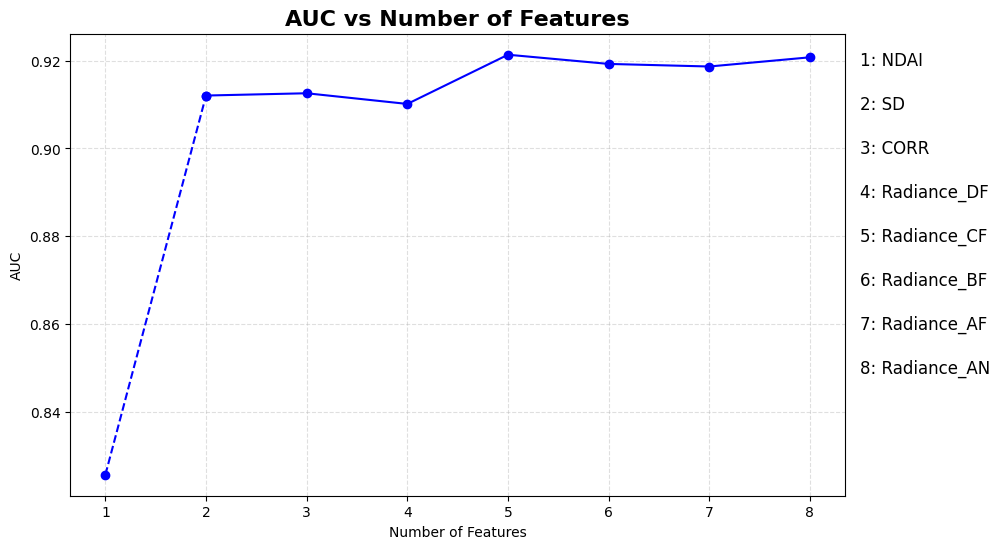

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Question: Do we need to drop X, Y, image_id?
# I drop this columns X, Y and image_id, but you can try to keep them and see the result
# X_train = train_df.drop(columns=['X', 'Y', 'image_id', 'Label'])
# y_train = train_df['Label']
# X_val = val_df.drop(columns=['X', 'Y', 'image_id', 'Label'])
# y_val = val_df['Label']

X_val = X_test.copy()
y_val = y_test.copy()

num_features = []
auc_scores = []
feature_names = X_train.columns

for i in range(1, len(X_train.columns) + 1):
    selected_features_train = X_train.iloc[:, :i]
    selected_features_val = X_val.iloc[:, :i]
    model = LogisticRegression(max_iter=1000, random_state=214)
    model.fit(selected_features_train, y_train)
    y_pred = model.predict_proba(selected_features_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    num_features.append(i)
    auc_scores.append(auc)

# Plot AUC vs Number of Features
plt.figure(figsize=(10, 6))
plt.plot(num_features[:2], auc_scores[:2], marker='o', linestyle='--', color='blue')
plt.plot(num_features[1:], auc_scores[1:], marker='o', linestyle='-', color='blue')
plt.title("AUC vs Number of Features", fontsize=16, fontweight='bold')
plt.xlabel("Number of Features")
plt.ylabel("AUC")
plt.grid(True, linestyle='--', alpha=0.4)

plt.xticks(num_features)
for i, txt in enumerate(feature_names):
    plt.text(len(feature_names) + 0.5, 0.92 - i * 0.01, f"{i+1}: {txt}", fontsize=12, verticalalignment='center')

plt.show()

In [22]:
# ===== Mann-Whitney U test =====
from scipy.stats import mannwhitneyu

p_values = {}
for features in features_to_plot:
    cloud = df_labeled[df_labeled['Label'] == 1][features]
    not_cloud = df_labeled[df_labeled['Label'] == -1][features]
    stat, p_value = mannwhitneyu(cloud, not_cloud, alternative='two-sided')
    p_values[features] = p_value

print("===== Mann-Whitney U test p-values =====")
sorted_p_values = sorted(p_values.items(), key=lambda x: x[1])
for feature, p_value in sorted_p_values:
    print(f"{feature}: {p_value:.4e}")


===== Mann-Whitney U test p-values =====
NDAI: 0.0000e+00
SD: 0.0000e+00
Radiance_DF: 0.0000e+00
Radiance_CF: 0.0000e+00
Radiance_BF: 0.0000e+00
Radiance_AF: 0.0000e+00
Radiance_AN: 0.0000e+00
CORR: 8.6214e-46


Key Observations from Mann-Whitney U Test:  
All features are statistically significant. The p-values for all features (NDAI, SD, CORR, and radiance angles) are extremely small (p≪0.05), indicating statistically significant differences in distributions between cloud (+1) and non-cloud (−1) classes.

In [ ]:
# ===== Quantify Feature-Label Association =====
correlation = df_labeled[features_to_plot + ['Label']].corr(method='spearman')['Label'].abs().sort_values(ascending=False)
print("===== Feature-Label Association =====")
print(correlation)

===== Feature-Label Association =====
Label          1.000000
SD             0.756609
NDAI           0.567453
Radiance_AF    0.519688
Radiance_AN    0.510974
Radiance_BF    0.465923
Radiance_CF    0.236613
Radiance_DF    0.104905
CORR           0.032128
Name: Label, dtype: float64


In [30]:
# ===== Feature Importance using Random Forest =====
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=214)
columns = df_labeled.drop(columns=['X', 'Y', 'image_id', 'Label']).columns
model.fit(df_labeled[columns], df_labeled['Label'])
importance = pd.Series(model.feature_importances_, index=columns).sort_values(ascending=False)
print("===== Feature Importance =====")
print(importance)

===== Feature Importance =====
SD             0.435629
NDAI           0.171823
Radiance_AN    0.086340
CORR           0.073200
Radiance_AF    0.070802
Radiance_DF    0.065616
Radiance_BF    0.060454
Radiance_CF    0.036136
dtype: float64


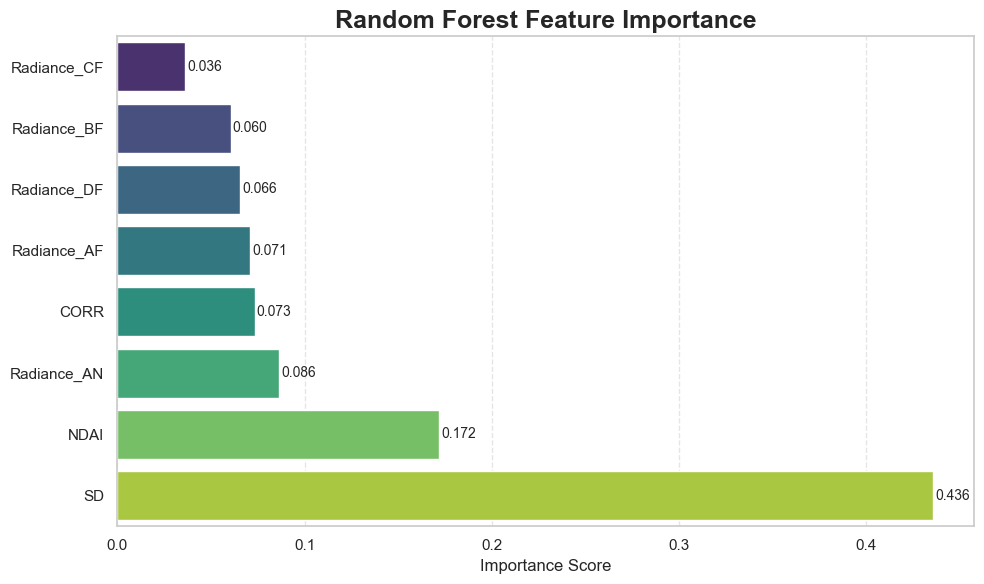

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

importance_df = importance.reset_index()
importance_df.columns = ['Feature', 'Importance']
importance_df = importance_df.sort_values(by='Importance', ascending=True)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

for i in range(len(importance_df)):
    barplot.text(
        x=importance_df['Importance'].iloc[i] + 0.001, 
        y=i, 
        s=f"{importance_df['Importance'].iloc[i]:.3f}", 
        va='center', 
        fontsize=10
    )

plt.title('Random Forest Feature Importance', fontsize=18, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


### Final Three Key Feature Selection 

**SD** stands out as a top predictor, achieving a Mann–Whitney U test p-value of 0.0, the highest Spearman correlation coefficient (0.735), and the strongest Random Forest feature importance (0.180). Its moderate correlation with NDAI (r = 0.4314) and low correlation with the other radiance variables (r < 0.3) demonstrate that it contributes unique information without significant redundancy. From a domain standpoint, SD captures local variability in radiance measurements, effectively distinguishing more turbulent, high-variance cloud regions from the homogeneous surfaces typical of non-cloud areas.

**NDAI** delivers high predictive power, evidenced by a single-feature AUC of 0.83 and the second-highest Spearman correlation (0.546). It also exhibits low pairwise correlations (< 0.3) with other features, reducing the risk of multicollinearity. Critically, NDAI was engineered specifically for cloud detection, as supported by prior literature, reinforcing its strong domain relevance.

**Radiance_AN** emerges as the best radiance-based feature, yielding the highest Spearman correlation (0.496) and notable Random Forest importance (0.046) among all radiance channels. Although it is extremely collinear with Radiance_AF (r = 0.9886) and Radiance_BF (r = 0.9447), selecting only Radiance_AN avoids introducing excessive redundancy while preserving the key discriminative information.

In combination, these three features—SD, NDAI, and Radiance_AN—demonstrate robust statistical significance, strong domain-based justification, and minimal overlap, making them the most effective predictors for cloud detection in this dataset.

## 4.2 Engineer New Features

### 4.2.1 Neighborhood Features

In [70]:
import numpy as np
import pandas as pd
from scipy.ndimage import generic_filter

def create_spatial_features_grouped(df_labeled, window_size=3):
    """
    group by image_id, and create spatial features for each pixel in the image.
    """
    spatial_features = ["NDAI_mean", "SD_std", "CORR_max"]
    for feat in spatial_features:
        df_labeled[feat] = np.nan
    
    for image_id, group in df_labeled.groupby("image_id"):
        # transform the group to a 2D array
        max_x = group["X"].max() + 1
        max_y = group["Y"].max() + 1
        image_data = group.sort_values(by=["Y", "X"])
        
        for idx, row in image_data.iterrows():
            y = row["Y"]
            x = row["X"]
            
            # define the neighborhood range (ensure within image boundaries)
            y_min = max(0, y - window_size//2)
            y_max = min(max_y, y + window_size//2 + 1)
            x_min = max(0, x - window_size//2)
            x_max = min(max_x, x + window_size//2 + 1)
                    
            # extract neighborhood data
            window = image_data[
                (image_data["Y"].between(y_min, y_max-1)) &
                (image_data["X"].between(x_min, x_max-1))
            ]
            
            # calculate statistics
            if not window.empty:
                df_labeled.loc[idx, "NDAI_mean"] = window["NDAI"].mean()
                df_labeled.loc[idx, "SD_std"] = window["SD"].std()
                df_labeled.loc[idx, "CORR_max"] = window["CORR"].max()
    
    return df_labeled

df_labeled = create_spatial_features_grouped(df_labeled)

### 4.2.2 Interactions 

In [ ]:
# ==== Interactions ====
df_labeled["NDAI_SD_Interaction"] = df_labeled["NDAI"] * df_labeled["SD"]
df_labeled["CORR_SD_Ratio"] = df_labeled["CORR"] / (df_labeled["SD"] + 1e-6)  

# Polynomial characteristics
df_labeled["NDAI_squared"] = df_labeled["NDAI"] ** 2
df_labeled["SD_log"] = np.log(df_labeled["SD"] + 1e-6) 

d:\anaconda\envs\stat214\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### 4.2.3 Radiation Angle Derived Features

In [55]:
# ==== Radiation Angle Derived Features ====
# Angle Difference
df_labeled["DF_AN_Diff"] = df_labeled["Radiance_DF"] - df_labeled["Radiance_AN"]
df_labeled["CF_AF_Diff"] = df_labeled["Radiance_CF"] - df_labeled["Radiance_AF"]

# Angle Ratio
df_labeled["DF_BF_Ratio"] = df_labeled["Radiance_DF"] / (df_labeled["Radiance_BF"] + 1e-6)

# Multiple Radiance Features
radiance_cols = ["Radiance_DF", "Radiance_CF", "Radiance_BF", "Radiance_AF", "Radiance_AN"]
df_labeled["Radiance_Mean"] = df_labeled[radiance_cols].mean(axis=1)
df_labeled["Radiance_Std"] = df_labeled[radiance_cols].std(axis=1)

### 4.2.4 Texture features (calculate entropy by grouping images)

In [ ]:
import warnings
from skimage.util import img_as_ubyte

warnings.filterwarnings("ignore", category=UserWarning, message=".*Possible precision loss converting image.*")
from skimage.filters.rank import entropy
from skimage.morphology import square

def calculate_texture_grouped(df_labeled, feature="NDAI", window_size=3):
    """
    group by image_id, calculate texture features using entropy
    """
    texture_col = f"{feature}_Entropy"
    df_labeled[texture_col] = np.nan
    
    for image_id, group in df_labeled.groupby("image_id"):
        group["X"] = group["X"].astype(int)
        group["Y"] = group["Y"].astype(int)
        # transfer into 2D image
        max_x = int(group["X"].max() + 1)
        max_y = int(group["Y"].max() + 1)
        image = np.full((max_y, max_x), np.nan)
        
        # fill the image
        for _, row in group.iterrows():
            image[row["Y"], row["X"]] = row[feature]
        image = np.nan_to_num(image)
        image = 2 * (image - np.min(image)) / (np.max(image) - np.min(image)) - 1
        
        # calculate entropy
        entropy_img = entropy(image, square(window_size))
        indices = group.sort_values(by=["Y", "X"]).index
        df_labeled.loc[indices, texture_col] = entropy_img.flatten()[:len(indices)]
    
    return df_labeled

df_labeled = calculate_texture_grouped(df_labeled, feature="NDAI")
df_labeled = calculate_texture_grouped(df_labeled, feature="SD")
df_labeled = calculate_texture_grouped(df_labeled, feature="CORR")

### 4.2.5 Features Correlation and Distribution

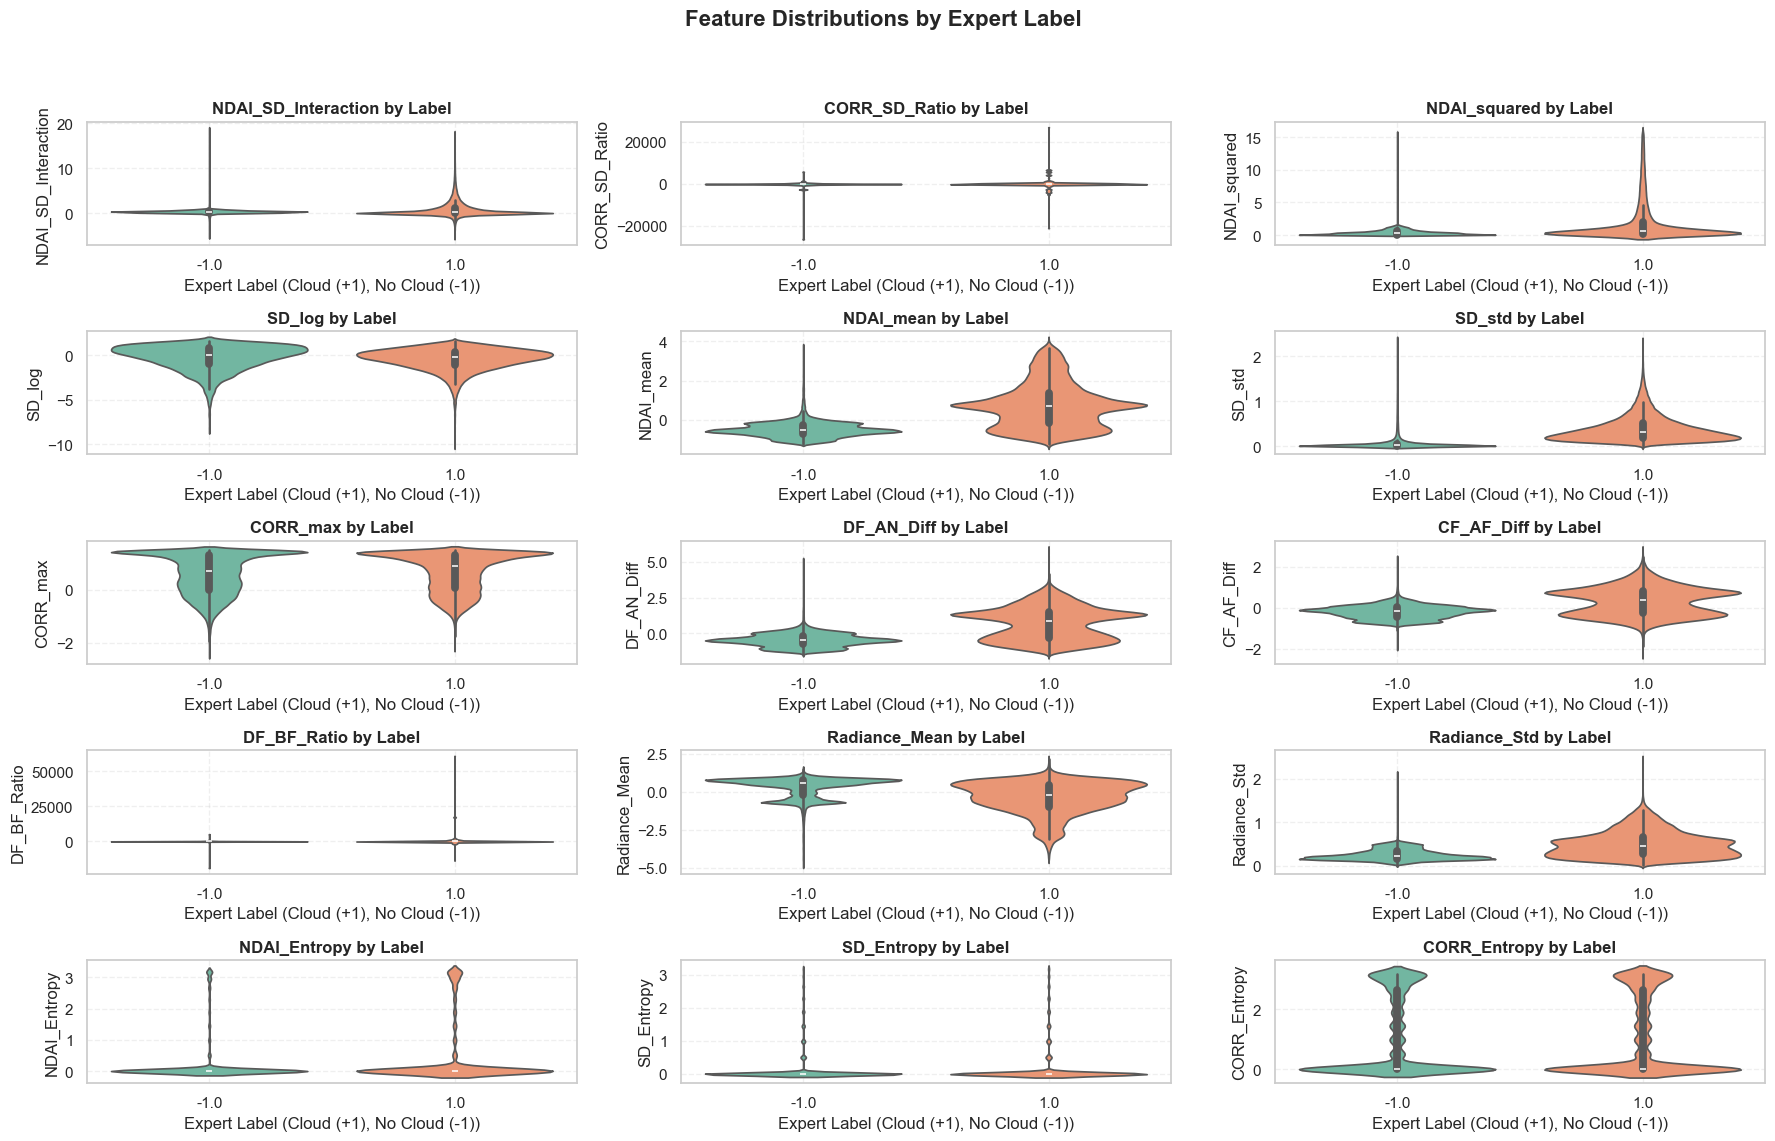

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ===== New Features Analysis =====
# Features correlation and distribution
new_features = ['NDAI_SD_Interaction', 'CORR_SD_Ratio', 'NDAI_squared', 'SD_log', 'NDAI_mean', 'SD_std', 'CORR_max', 'DF_AN_Diff', 'CF_AF_Diff', 'DF_BF_Ratio', 'Radiance_Mean', 'Radiance_Std', 'NDAI_Entropy', 'SD_Entropy', 'CORR_Entropy']
n_rows = 5
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
axes = axes.flatten()

for idx, feature in enumerate(new_features):
    sns.violinplot(ax=axes[idx], data=df_labeled, x='Label', y=feature, inner='box', palette='Set2')
    axes[idx].set_title(f"{feature} by Label", fontsize=12, fontweight='bold')
    axes[idx].set_xlabel("Expert Label (Cloud (+1), No Cloud (-1))")
    axes[idx].set_ylabel(feature)
    axes[idx].grid(True, linestyle='--', alpha=0.3)

for i in range(len(new_features), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle("Feature Distributions by Expert Label", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

C:\Users\ALEX\AppData\Local\Temp\ipykernel_25032\1437779336.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


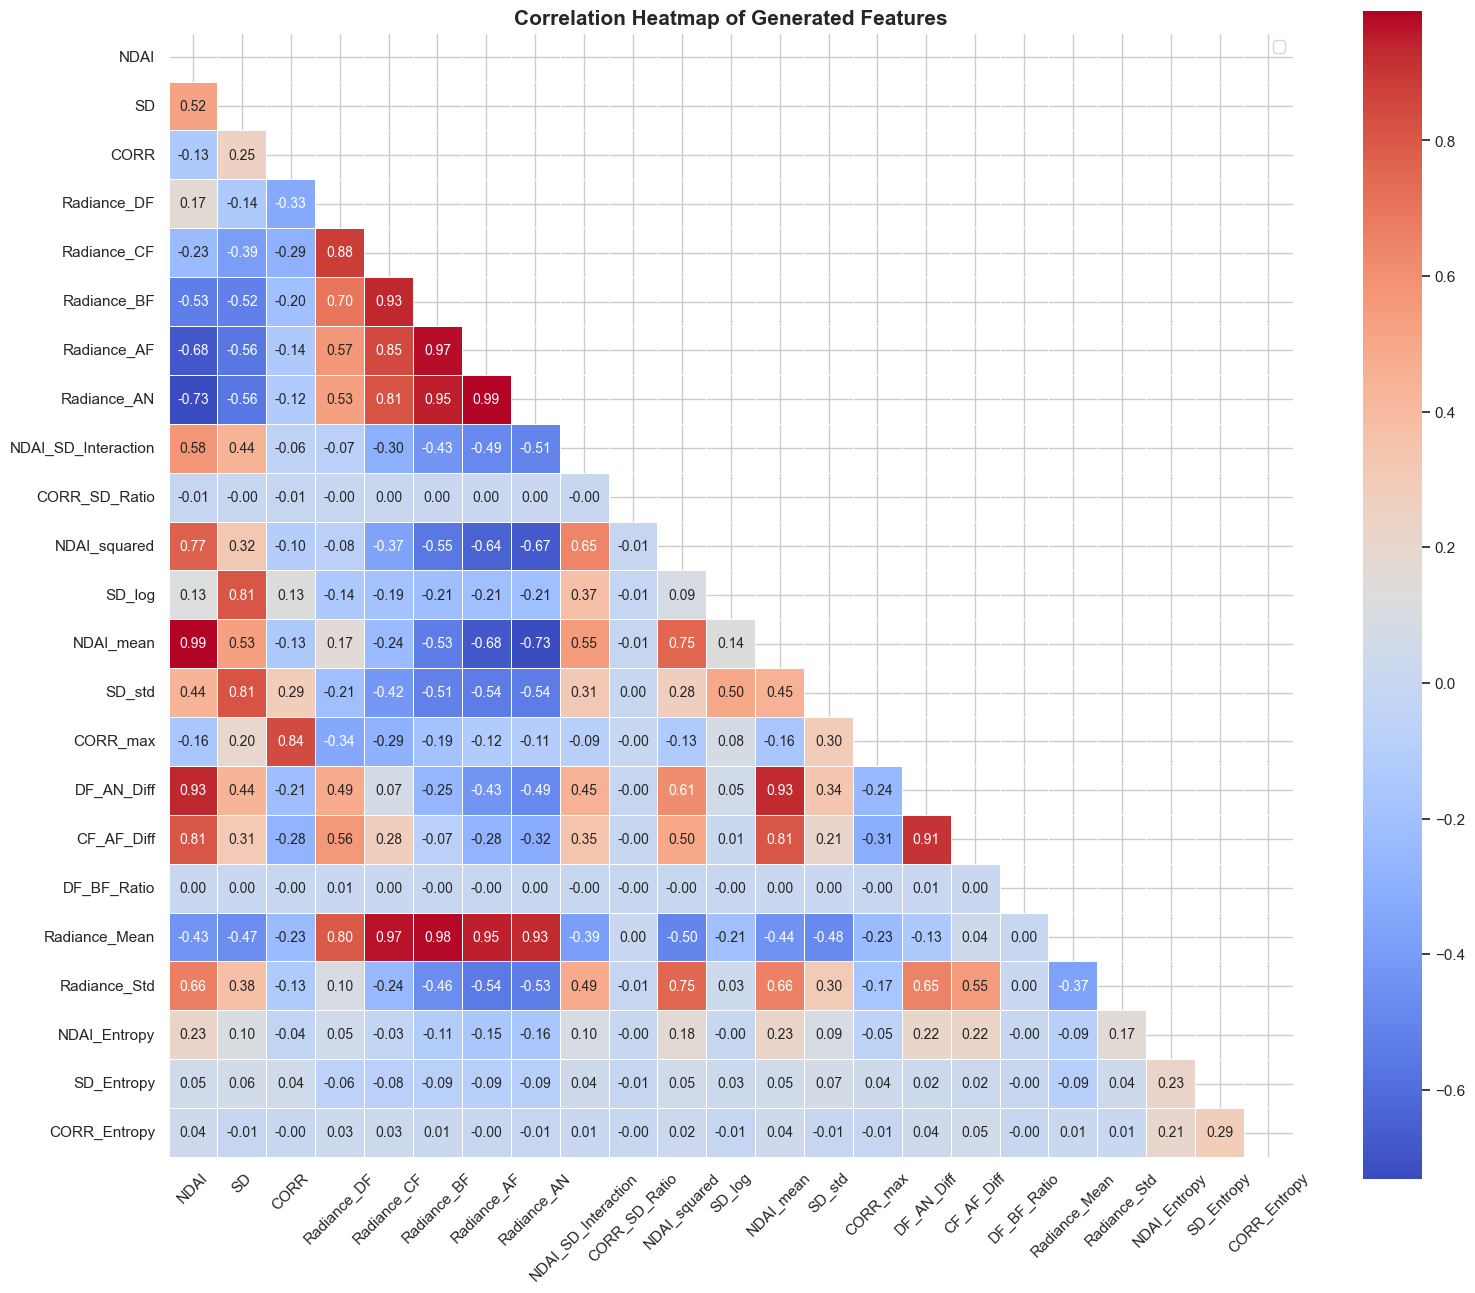

In [63]:
# ===== Correlation Heatmap of New Features =====
numeric_df = df_labeled.select_dtypes(include='number').drop(columns=['X', 'Y', 'Label'])
correlation = numeric_df.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))

plt.figure(figsize=(16, 16))
sns.heatmap(correlation, mask=mask, cmap='coolwarm', annot=True, fmt=".2f",
            square=True, linewidths=0.6, cbar_kws={"shrink": 0.75}, annot_kws={"size":10})
plt.title("Correlation Heatmap of Generated Features", fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.legend()
plt.show()

### 4.2.6 Statistical significance test

In [72]:
from scipy.stats import ttest_ind, mannwhitneyu

new_features = ['NDAI_SD_Interaction', 'CORR_SD_Ratio', 'NDAI_squared', 'SD_log', 'NDAI_mean', 'SD_std', 'CORR_max', 'DF_AN_Diff', 'CF_AF_Diff', 'DF_BF_Ratio', 'Radiance_Mean', 'Radiance_Std', 'NDAI_Entropy', 'SD_Entropy', 'CORR_Entropy']
test_results = []

# Perform statistical tests for each new feature
for feature in new_features:
    cloud = df_labeled[df_labeled['Label'] == 1][feature]
    not_cloud = df_labeled[df_labeled['Label'] == -1][feature]
    
    # Check normality assumption
    if cloud.skew() < 2 and not_cloud.skew() < 2:
        # Use t-test if data is approximately normal
        stat, p_value = ttest_ind(cloud, not_cloud, equal_var=False)
        test_name = 't-test'
    else:
        # Use Mann-Whitney U test if data is not normal
        stat, p_value = mannwhitneyu(cloud, not_cloud, alternative='two-sided')
        test_name = 'Mann-Whitney U test'
    
    test_results.append((feature, test_name, p_value))

sorted_results = sorted(test_results, key=lambda x: x[2])
for feature, test_name, p_value in sorted_results:
    print(f"{feature}: {test_name} p-value = {p_value:.4e}")

NDAI_squared: Mann-Whitney U test p-value = 0.0000e+00
NDAI_mean: Mann-Whitney U test p-value = 0.0000e+00
DF_AN_Diff: t-test p-value = 0.0000e+00
CF_AF_Diff: t-test p-value = 0.0000e+00
Radiance_Mean: t-test p-value = 0.0000e+00
Radiance_Std: t-test p-value = 0.0000e+00
NDAI_Entropy: Mann-Whitney U test p-value = 0.0000e+00
CORR_max: t-test p-value = 5.8247e-118
NDAI_SD_Interaction: Mann-Whitney U test p-value = 9.0869e-79
CORR_SD_Ratio: Mann-Whitney U test p-value = 2.6220e-03
SD_log: t-test p-value = nan
SD_std: Mann-Whitney U test p-value = nan
SD_Entropy: Mann-Whitney U test p-value = 2.3836e-25
DF_BF_Ratio: Mann-Whitney U test p-value = 2.7132e-20
CORR_Entropy: t-test p-value = 9.2770e-01


In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

baseline_features = ['NDAI', 'SD', 'CORR', 'Radiance_DF', 'Radiance_CF', 'Radiance_BF', 'Radiance_AF', 'Radiance_AN']
enhanced_features = ['NDAI_SD_Interaction', 'CORR_SD_Ratio', 'NDAI_squared', 'SD_log', 'NDAI_mean', 'SD_std', 'CORR_max', 'DF_AN_Diff', 'CF_AF_Diff', 'DF_BF_Ratio', 'Radiance_Mean', 'Radiance_Std', 'NDAI_Entropy', 'SD_Entropy', 'CORR_Entropy']

# cross-validation
baseline_scores = cross_val_score(RandomForestClassifier(), df_labeled[baseline_features], df_labeled['Label'], cv=5)
enhanced_scores = cross_val_score(RandomForestClassifier(), df_labeled[enhanced_features], df_labeled['Label'], cv=5)
print(f"Baseline F1: {baseline_scores.mean():.3f}, Enhanced F1: {enhanced_scores.mean():.3f}")

Baseline F1: 0.842, Enhanced F1: 0.865


In [74]:
# ===== Feature Importance using Random Forest =====
from sklearn.ensemble import RandomForestClassifier

print("===== Feature Importance =====")
print("===== Baseline Features =====")
model = RandomForestClassifier().fit(df_labeled[baseline_features], df_labeled['Label'])
importance = pd.Series(model.feature_importances_, index=baseline_features).sort_values(ascending=False)
print(importance)

print("===== Enhanced Features =====")
model = RandomForestClassifier().fit(df_labeled[enhanced_features], df_labeled['Label'])
importance = pd.Series(model.feature_importances_, index=enhanced_features).sort_values(ascending=False)
print(importance)

===== Feature Importance =====
===== Baseline Features =====
SD             0.399935
NDAI           0.178433
Radiance_AN    0.099288
Radiance_DF    0.077724
CORR           0.073448
Radiance_AF    0.069394
Radiance_BF    0.060580
Radiance_CF    0.041199
dtype: float64
===== Enhanced Features =====
SD_std                 0.271412
SD_log                 0.129755
NDAI_mean              0.129308
DF_AN_Diff             0.109407
NDAI_SD_Interaction    0.078115
CF_AF_Diff             0.062265
CORR_max               0.057405
Radiance_Mean          0.042970
CORR_SD_Ratio          0.028756
NDAI_squared           0.028309
Radiance_Std           0.027551
DF_BF_Ratio            0.026251
CORR_Entropy           0.003906
NDAI_Entropy           0.002689
SD_Entropy             0.001900
dtype: float64


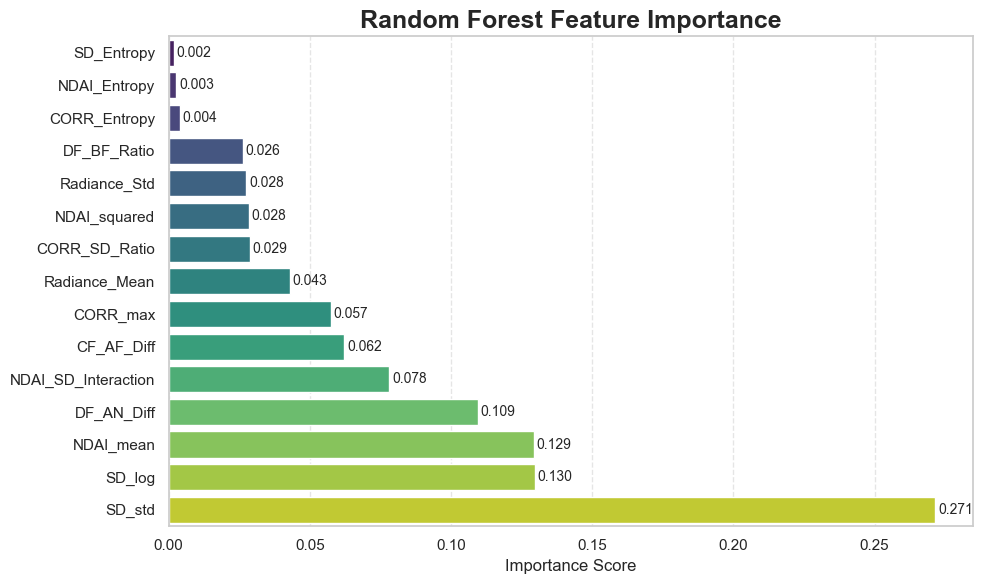

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

importance_df = importance.reset_index()
importance_df.columns = ['Feature', 'Importance']
importance_df = importance_df.sort_values(by='Importance', ascending=True)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

for i in range(len(importance_df)):
    barplot.text(
        x=importance_df['Importance'].iloc[i] + 0.001, 
        y=i, 
        s=f"{importance_df['Importance'].iloc[i]:.3f}", 
        va='center', 
        fontsize=10
    )

plt.title('Random Forest Feature Importance', fontsize=18, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

## 4.3 Transfer learning